# Homework 8

- Bryan Maus
- Greycin Kim

1. Consider the following short documents:

Document 1: how do you do

Document 2: how are you

Document 3: how do you feel


In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [2]:
import pandas as pd
docs = pd.Series(["how do you do", "how are you", "how do you feel"])

In [3]:
vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(docs)

In [4]:
df = pd.DataFrame(
    X_counts.toarray(),
    columns=vectorizer.get_feature_names_out()
).T

df.columns = [f"Document {i+1}" for i in range(df.shape[1])]


In [5]:
df

,Document 1,Document 2,Document 3
are,0,1,0
do,2,0,1
feel,0,0,1
how,1,1,1
you,1,1,1


## Part a: TF

In [6]:
term_counts_df = df.T
tf_df = term_counts_df.div(term_counts_df.sum(axis=1), axis=0).T
print(tf_df)

      Document 1  Document 2  Document 3
are         0.00    0.333333        0.00
do          0.50    0.000000        0.25
feel        0.00    0.000000        0.25
how         0.25    0.333333        0.25
you         0.25    0.333333        0.25


## Part b:

In [7]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_counts)

idf_values = tfidf_transformer.idf_
idf_df = pd.Series(idf_values, index=vectorizer.get_feature_names_out())

In [8]:
idf_df

are     1.693147
do      1.287682
feel    1.693147
how     1.000000
you     1.000000
dtype: float64

## Part C

In [9]:
X_tfidf = tfidf_transformer.transform(X_counts)

tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=vectorizer.get_feature_names_out()
)
tfidf_df.index = [f"Document {i+1}" for i in range(len(docs))]

tfidf_df.T


,Document 1,Document 2,Document 3
are,0.000000,0.767495,0.000000
do,0.876537,0.000000,0.504107
feel,0.000000,0.000000,0.662840
how,0.340355,0.453295,0.391484
you,0.340355,0.453295,0.391484


## Part D:
Most important is do

# Question 2

Download the CSV file on Canvas called airline_tweets_sentiment_utf8.csv that
contains tweets about airlines . The goal is to create a word cloud from the most frequent1
words in the “tweet” column after some pre-processing. Write Python code to do the following
tasks (please refer to the text processing Python code used in class on GitHub). You must use
the nltk and wordcloud packages (and not any other text processing package

a) Load the given CSV

In [10]:
import pandas as pd
df_tweets = pd.read_csv("./data/airline_tweets_sentiment_utf8.csv")

b) What is the full text of the first tweet?

In [11]:
print(df_tweets.loc[0, "tweet"])

@united yes. We waited in line for almost an hour to do so. Some passengers just left not wanting to wait past 1am.


c) Convert your data to the “tidy” format, i.e., one word per row. (Hint: use
nltk.tokenize.TweetTokenizer and pandas.DataFrame.explode.) How many words are
there? [code, number of words

In [12]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()
df_tweets["tokens"] = df_tweets["tweet"].apply(tokenizer.tokenize)

tidy_df = df_tweets[["tweet_id", "tokens"]].explode("tokens").reset_index(drop=True)

print(f"Total number of words: {len(tidy_df)}")


Total number of words: 293537


d) Remove stop words from the tidy dataset. How many words are there? [code, number of
words]

In [13]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
tidy_df["tokens"] = tidy_df["tokens"].str.lower()
filtered_df = tidy_df[~tidy_df["tokens"].isin(stop_words)]

print(f"Number of words after removing stopwords: {len(filtered_df)}")

Number of words after removing stopwords: 186357


e) Calculate the word count for each word and sort them with the most frequent words first.
How many unique words are there? What are the 10 most frequent words with counts?
[code, list of 10 word-counts]

In [14]:
word_counts = filtered_df["tokens"].value_counts()
print(f"Unique words: {word_counts.shape[0]}")
print("Top 10 most frequent words:\n", word_counts.head(10))

Unique words: 16712
Top 10 most frequent words:
 tokens
.                13723
!                 5080
?                 4608
,                 4158
flight            3898
@united           3892
@usairways        2998
@americanair      2961
@southwestair     2458
@jetblue          2248
Name: count, dtype: int64


f) Create a word cloud of the 50 most frequent words. (Hint: use the max_words parameter
to WordCloud()). [code, picture of word cloud]

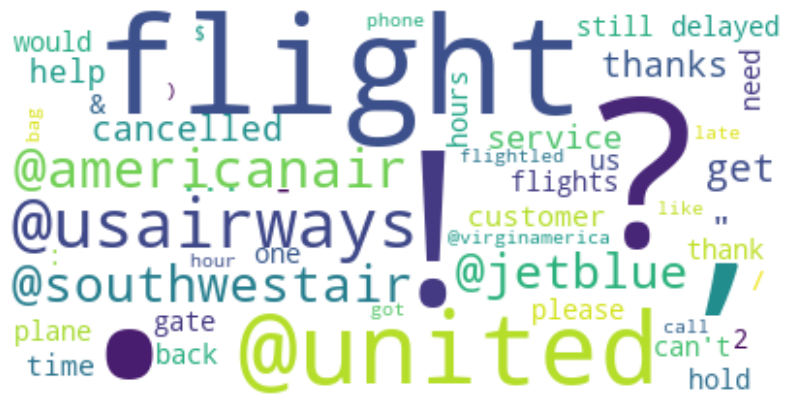

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(max_words=50, background_color="white").generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Question 3: Compute the cosine similarity between vectors (1, 2, 3) and (0, 2, 5)

a. Use scipy.spatial.distance.cosine()

In [16]:
from scipy.spatial.distance import cosine

v1 = [1, 2, 3]
v2 = [0, 2, 5]

cosine_distance = cosine(v1, v2)
cosine_similarity = 1 - cosine_distance
print("Cosine similarity (scipy):", cosine_similarity)

Cosine similarity (scipy): 0.9429541672723837


b. Use sklearn.metrics.pairwise.cosine_similarity()

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

cos_sim = cosine_similarity([v1], [v2])
print("Cosine similarity (sklearn):", cos_sim[0][0])

Cosine similarity (sklearn): 0.9429541672723838


c. Use sklearn.metrics.pairwise.linear_kernel() and sklearn.preprocessing.normalize()

In [18]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import normalize

v1_norm = normalize([v1])
v2_norm = normalize([v2])

cos_sim = linear_kernel(v1_norm, v2_norm)
print("Cosine similarity (linear_kernel):", cos_sim[0][0])

Cosine similarity (linear_kernel): 0.9429541672723838


# Question 4

Use the same CSV file from Problem 2. Each tweet also has an associated “sentiment” -
whether the expressed opinion in the tweet is positive, negative, or neutral. The goal is to use
this data to predict the sentiment of the first tweet .

a) Calculate the tf-idf weight for each word and tweet_id. [code]

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df_tweets["tweet"])

tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    index=df_tweets["tweet_id"],
    columns=tfidf_vectorizer.get_feature_names_out()
)


b) How many unique words are present? [code]

In [20]:
print(f"Unique words in TF-IDF: {len(tfidf_vectorizer.get_feature_names_out())}")

Unique words in TF-IDF: 14788


c) Predict the sentiment of the first tweet (with tweet_id = “567591480085463000”) using
the 1-Nearest Neighbor approach with cosine similarity.

○ Write code to compare the tf-idf vector of the first tweet to that of the remaining
tweets using the cossim function from Problem 3. The sentiment of the tweet with
the highest similarity will then be the predicted sentiment. [code]

■ Hints: the first column in your tf-idf table may not correspond to the
original first tweet. The “first” tweet is that with tweet_id =
567591480085463000.

■ to get the names of columns, use
vectorizer.get_feature_names_out()

In [23]:
target_id = 567591480085463000
target_vec = tfidf_df.loc[target_id].values.reshape(1, -1)

# Remove target tweet to avoid self-comparison
other_df = tfidf_df.drop(index=target_id)

similarities = cosine_similarity(target_vec, other_df.values)[0]
most_similar_idx = similarities.argmax()

most_similar_tweet_id = other_df.index[most_similar_idx]
most_similar_text = df_tweets[df_tweets["tweet_id"] == most_similar_tweet_id]["tweet"].values[0]
predicted_sentiment = df_tweets[df_tweets["tweet_id"] == most_similar_tweet_id]["airline_sentiment"].values[0]

What is the tweet_id of the most similar tweet(s)? What is the text of this
tweet(s)? What is its sentiment (this is the predicted sentiment)?

In [24]:
print("Most similar tweet ID:", most_similar_tweet_id)
print("Most similar tweet text:", most_similar_text)
print("Predicted sentiment:", predicted_sentiment)

Most similar tweet ID: 568803260569690000
Most similar tweet text: @united past
Predicted sentiment: neutral


Does the predicted sentiment match its known sentiment (from row 1)?

In [25]:
true_sentiment = df_tweets[df_tweets["tweet_id"] == target_id]["airline_sentiment"].values[0]
print("Actual sentiment:", true_sentiment)
print("Match:", predicted_sentiment == true_sentiment)

Actual sentiment: negative
Match: False


d) Is this bag-of-words approach in general a good way to predict sentiment in tweets? Why
or why not? Answer in 2-3 sentences.

The bag-of-words often fails to capture the nuances of sentiment. It ignores word order, context, sarcasm, and tone, which are crucial for understanding emotional content in tweets. More advanced models like transformers or recurrent neural networks are generally better suited for sentiment analysis.